#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf


#티스토리 업로드시 최적화 코드
#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:90% !important;}</style>"))

# 2023.04.28
#EDA

In [1]:
import pandas as pd

In [1]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 


In [2]:
file_dir = 'C:/workplace/dacon/wall'

In [3]:
all_img_list = glob.glob(file_dir + '/train/*/*')

In [4]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('\\')[-2]).astype(str)

In [5]:
df

,img_path,label
0,C:/workplace/dacon/wall/train\가구수정\0.png,가구수정
1,C:/workplace/dacon/wall/train\가구수정\1.png,가구수정
2,C:/workplace/dacon/wall/train\가구수정\10.png,가구수정
3,C:/workplace/dacon/wall/train\가구수정\11.png,가구수정
4,C:/workplace/dacon/wall/train\가구수정\2.png,가구수정
...,...,...
3452,C:/workplace/dacon/wall/train\훼손\995.png,훼손
3453,C:/workplace/dacon/wall/train\훼손\996.png,훼손
3454,C:/workplace/dacon/wall/train\훼손\997.png,훼손
3455,C:/workplace/dacon/wall/train\훼손\998.png,훼손


In [6]:
count_lb = df['label'].value_counts().to_frame().reset_index()
count_lb.columns = ['label','count']
count_lb

,label,count
0,훼손,1405
1,오염,595
2,걸레받이수정,307
3,꼬임,210
4,터짐,162
5,곰팡이,145
6,오타공,142
7,몰딩수정,130
8,면불량,99
9,석고수정,57


In [7]:
from sklearn.preprocessing import LabelEncoder
df['label'] = [str(i) for i in df['label']]
le = LabelEncoder()

df['label_num'] = le.fit_transform(df['label'])
labels = df[['label_num','label']].drop_duplicates().reset_index(drop = True)
labels = pd.merge(labels, count_lb, on = 'label', how ='inner' )

In [8]:
le.classes_

array(['가구수정', '걸레받이수정', '곰팡이', '꼬임', '녹오염', '들뜸', '면불량', '몰딩수정', '반점',
       '석고수정', '오염', '오타공', '울음', '이음부불량', '창틀,문틀수정', '터짐', '틈새과다', '피스',
       '훼손'], dtype=object)

In [9]:
def label_decoder(pred):
	if pred==0:
		return '가구수정'
	if pred==1:
		return '걸레받이수정'
	if pred==2:	
		return '곰팡이' 
	if pred==3:	
		return '꼬임'   
	if pred==4:	
		return '녹오염' 
	if pred==5:	
		return '들뜸' 
	if pred==6:	
		return '면불량' 
	if pred==7:	
		return '몰딩수정'
	if pred==8:	
		return '반점' 
	if pred==9:	
		return '석고수정'
	if pred==10:	
		return '오염' 
	if pred==11:	
		return '오타공' 
	if pred==12:	
		return '울음' 
	if pred==13:	
		return '이음부불량' 
	if pred==14:	
		return '창틀,문틀수정' 
	if pred==15:	
		return '터짐' 
	if pred==16:	
		return '틈새과다'
	if pred==17:	
		return '피스' 
	if pred==18:	
		return '훼손' 
	else:
		return 'NaN' 
     

In [10]:
df['re_label'] = [label_decoder(i) for i in df.label_num]

In [11]:
labels['re_label'] = [label_decoder(i) for i in labels.label_num]

In [12]:
labels = labels.sort_values(by = 'count', ascending = False)

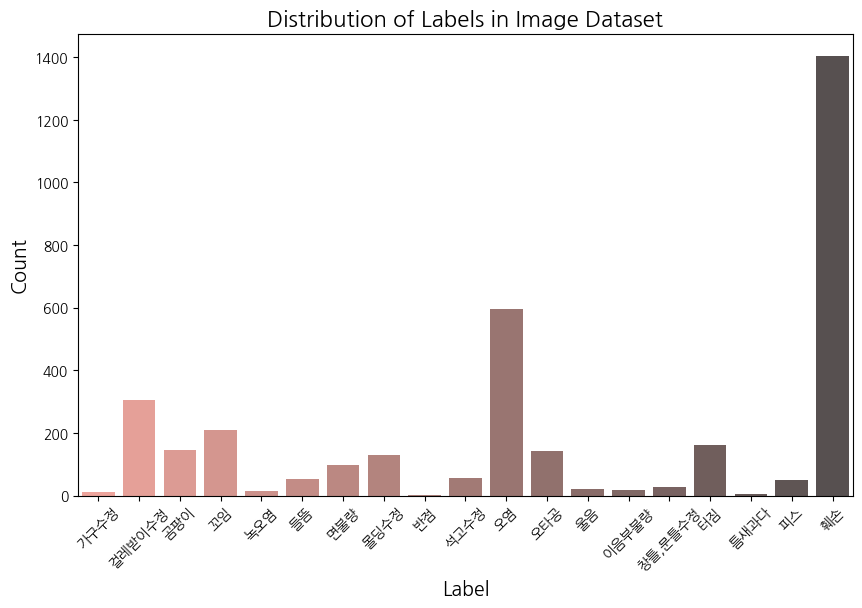

In [13]:
import matplotlib
import matplotlib.pyplot as plt
# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns


#한글 display 안됨. 수정 필요
matplotlib.rcParams['font.family'] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

x = labels['label_num']
y = labels['count']

plt.figure(figsize=(10, 6))
sns.barplot(x=x, y=y.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(labels['label_num'], labels['re_label'])
plt.xticks(rotation=45)
plt.show()


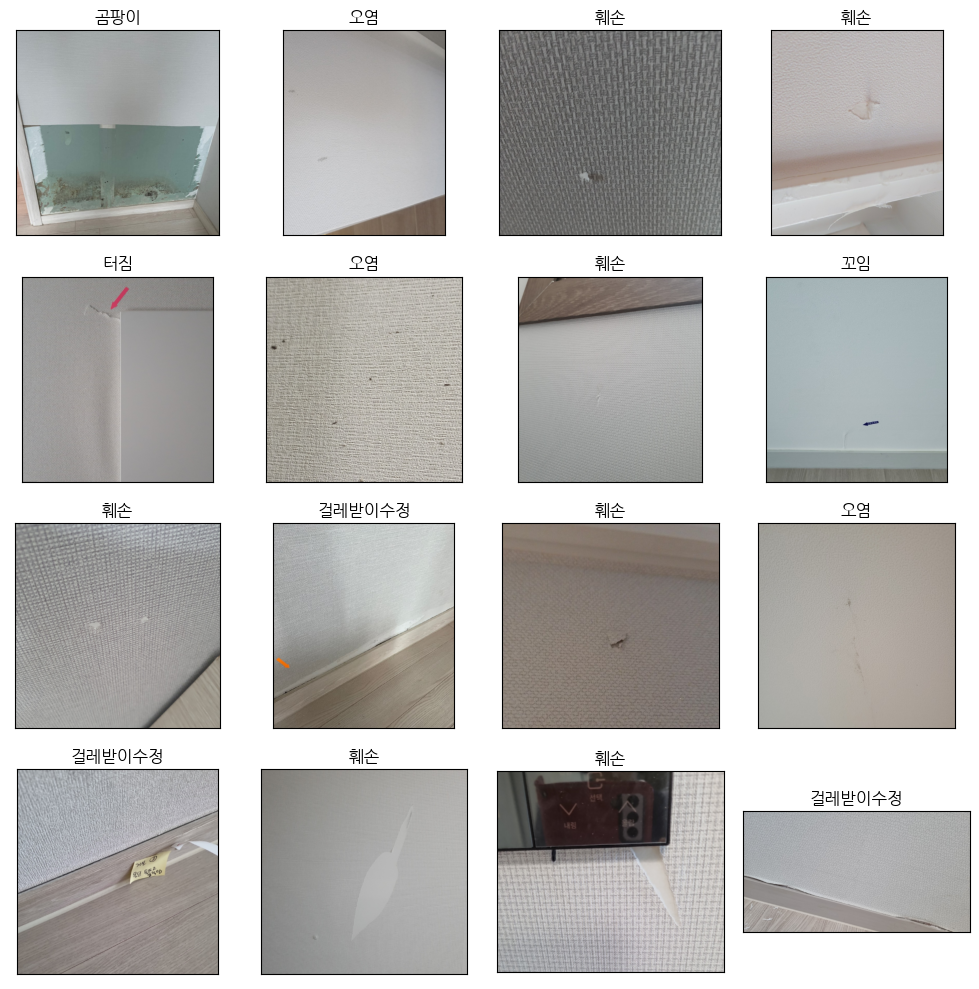

In [14]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.img_path[random_index[i]]))
    ax.set_title(df.re_label[random_index[i]])
plt.tight_layout()
plt.show()


In [15]:
# Tensorflow Libraries
from tensorflow import keras
from keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import EfficientNetB7
from keras import Model
from keras.preprocessing import image
from pathlib import Path
import os

In [16]:
import tensorflow as tf

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [17]:
test = pd.read_csv(file_dir+'/test.csv')

In [18]:
test['img_path'] = test['img_path'].str.replace('./test', file_dir + '/test')
test

,id,img_path
0,TEST_000,C:/workplace/dacon/wall/test/000.png
1,TEST_001,C:/workplace/dacon/wall/test/001.png
2,TEST_002,C:/workplace/dacon/wall/test/002.png
3,TEST_003,C:/workplace/dacon/wall/test/003.png
4,TEST_004,C:/workplace/dacon/wall/test/004.png
...,...,...
787,TEST_787,C:/workplace/dacon/wall/test/787.png
788,TEST_788,C:/workplace/dacon/wall/test/788.png
789,TEST_789,C:/workplace/dacon/wall/test/789.png
790,TEST_790,C:/workplace/dacon/wall/test/790.png


In [19]:
train_df = df[['img_path', 'label']]

In [20]:

# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='label',
    target_size=(600, 600),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='label',
    target_size=(600, 600),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='img_path',
    target_size=(600, 600),
    color_mode='rgb',
    class_mode=None,
    batch_size=32,
    seed=42,
)

Found 2766 validated image filenames belonging to 19 classes.
Found 691 validated image filenames belonging to 19 classes.


In [197]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [179]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])


In [21]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB7(
    input_shape=(600, 600, 3),
    include_top=False,
    # weights='noisy-student path', # https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b7.tar.gz 가중치 링크 / 이거 쓰는게 더 좋긴할거임
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


In [35]:
pretrained_model.output

<KerasTensor: shape=(None, 2560) dtype=float32 (created by layer 'avg_pool')>

In [22]:
# Create checkpoint callback
from keras.callbacks import ReduceLROnPlateau

checkpoint_path = "wallpaper_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

In [23]:
from keras.optimizers import Adam
from keras.layers import Dense, Dropout
from helper_functions import create_tensorboard_callback

inputs = pretrained_model.input

# unit수, dropout 등은 조정이 필요함.
x = Dense(64, activation='relu')(pretrained_model.output)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)

#도출될 클래스 수 정하기
outputs = Dense(19, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.1),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        reduce_lr,
        checkpoint_callback,
    ]
)

Epoch 1/100
62/87 [====================>.........] - ETA: 16:23 - loss: 3.2599 - accuracy: 0.4682

In [203]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
# Display the result
print(f'The first 5 predictions: {pred[:5]}')

2023-05-01 12:27:39.222192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - 8s 316ms/step
The first 5 predictions: ['오타공', '훼손', '꼬임', '걸레받이수정', '훼손']


In [214]:
dataset = file_dir+'/test'
walk_through_dir(dataset);

image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png')) #list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
test_df_1 = pd.concat([filepaths, labels], axis=1)

There are 1 directories and 792 images in '도배하자유형분류/test'.
There are 0 directories and 1 images in '도배하자유형분류/test/.ipynb_checkpoints'.


In [218]:
test_df_1 = test_df_1[test_df_1['Label'] != '.ipynb_checkpoints']

In [219]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df_1,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 792 validated image filenames belonging to 1 classes.


In [220]:
pred_test = model.predict(test_images)

2023-05-01 15:09:45.851813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - 8s 315ms/step


In [221]:
pred_test = np.argmax(pred_test,axis=1)

In [222]:
submit = pd.read_csv(file_dir + '/sample_submission.csv')

In [223]:
submit['label'] = pred_test

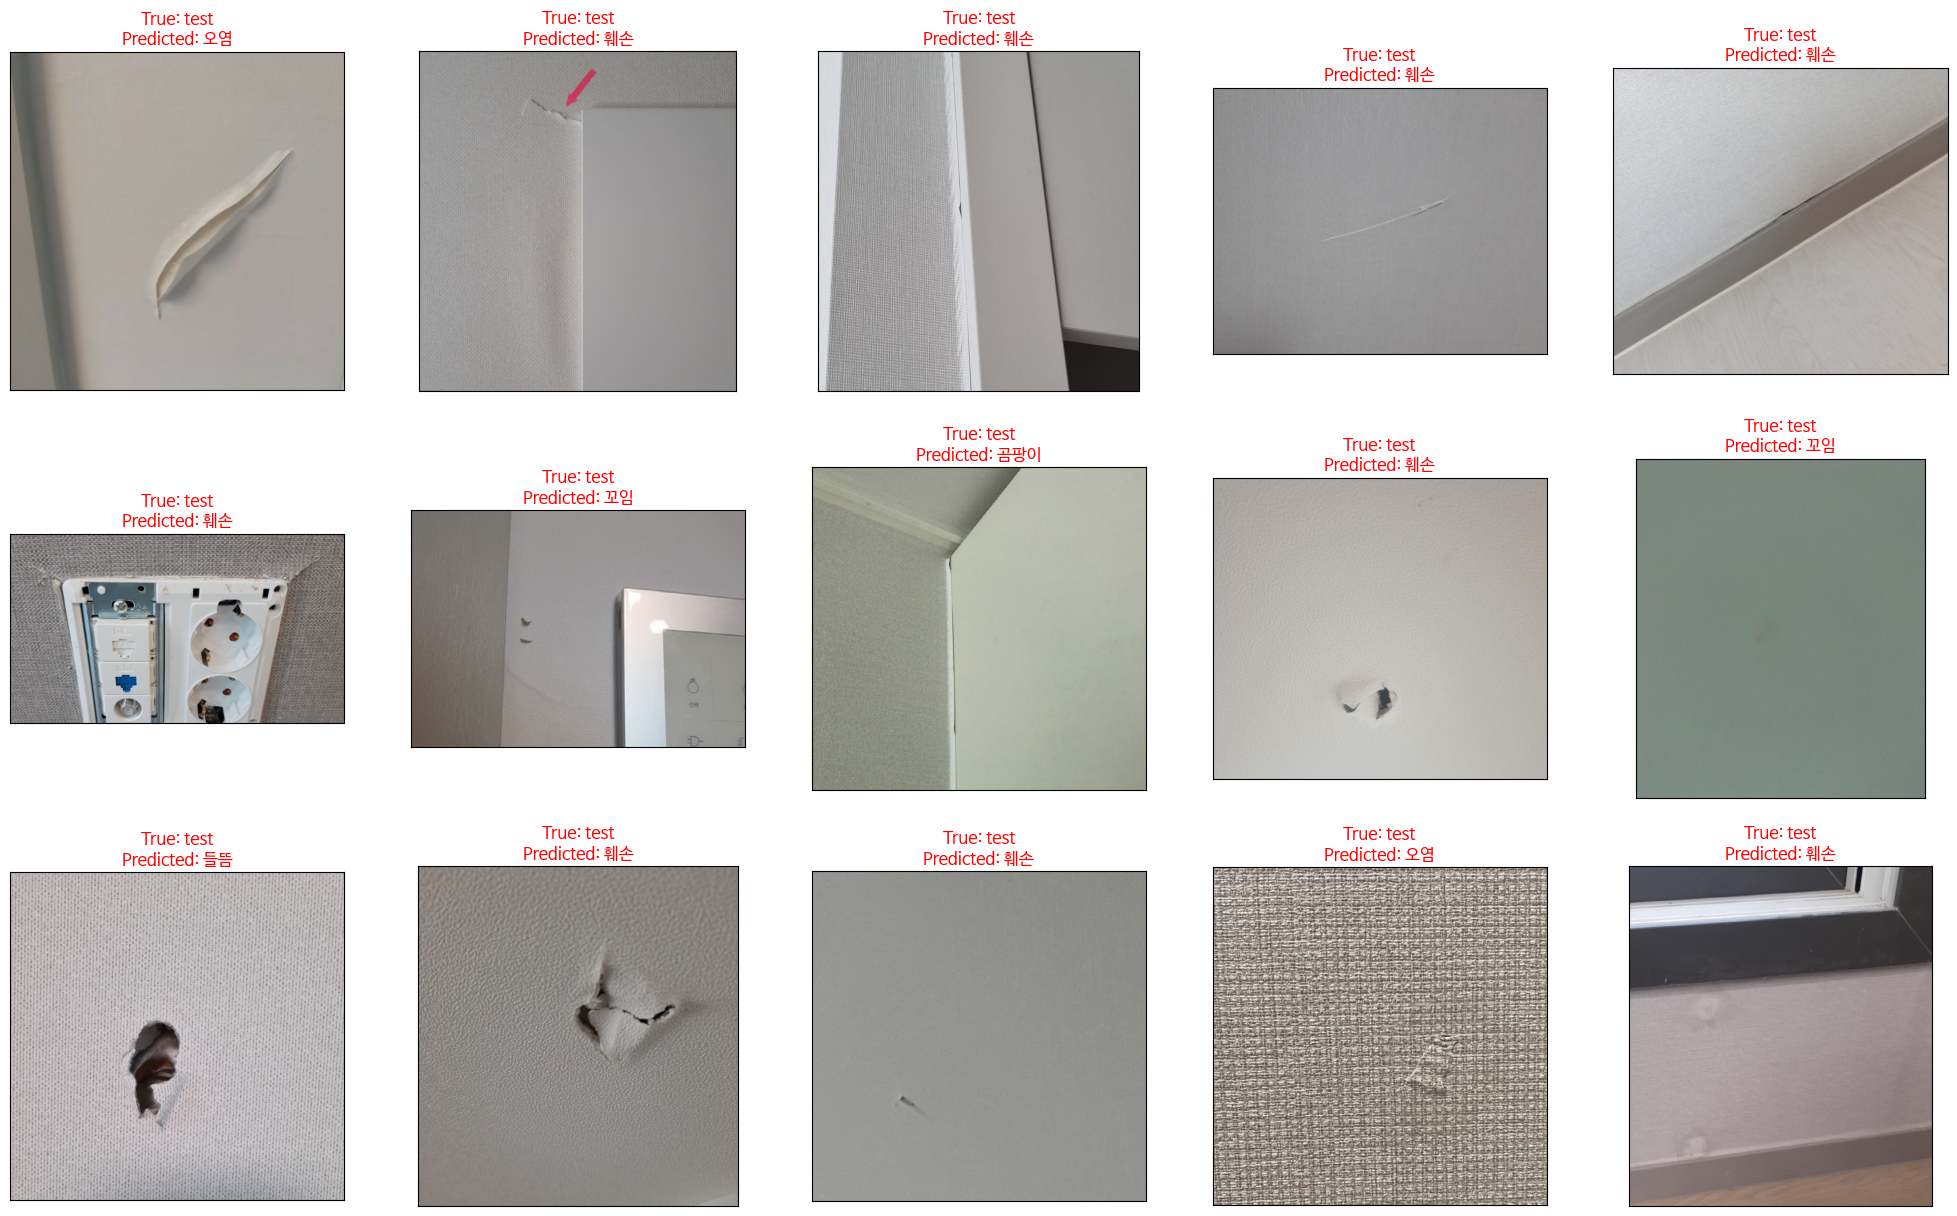

<Figure size 640x480 with 0 Axes>

In [224]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df_1) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df_1.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df_1.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [226]:
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: '가구수정',
 1: '걸레받이수정',
 2: '곰팡이',
 3: '꼬임',
 4: '녹오염',
 5: '들뜸',
 6: '면불량',
 7: '몰딩수정',
 8: '반점',
 9: '석고수정',
 10: '오염',
 11: '오타공',
 12: '울음',
 13: '이음부불량',
 14: '창틀,문틀수정',
 15: '터짐',
 16: '틈새과다',
 17: '피스',
 18: '훼손'}

In [227]:
# Map the label to train set
submit.loc[submit['label'] == 0, 'label'] = '가구수정'
submit.loc[submit['label'] == 1, 'label'] = '걸레받이수정'
submit.loc[submit['label'] == 2, 'label'] = '곰팡이'
submit.loc[submit['label'] == 3, 'label'] = '꼬임'
submit.loc[submit['label'] == 4, 'label'] = '녹오염'
submit.loc[submit['label'] == 5, 'label'] = '들뜸'
submit.loc[submit['label'] == 6, 'label'] = '면불량'
submit.loc[submit['label'] == 7, 'label'] = '몰딩수정'
submit.loc[submit['label'] == 8, 'label'] = '반점'
submit.loc[submit['label'] == 9, 'label'] = '석고수정'
submit.loc[submit['label'] == 10, 'label'] = '오염'
submit.loc[submit['label'] == 11, 'label'] = '오타공'
submit.loc[submit['label'] == 12, 'label'] = '울음'
submit.loc[submit['label'] == 13, 'label'] = '이음부불량'
submit.loc[submit['label'] == 14, 'label'] = '창틀,문틀수정'
submit.loc[submit['label'] == 15, 'label'] = '터짐'
submit.loc[submit['label'] == 16, 'label'] = '틈새과다'
submit.loc[submit['label'] == 17, 'label'] = '피스'
submit.loc[submit['label'] == 18, 'label'] = '훼손'

In [228]:
submit

,id,label
0,TEST_000,오타공
1,TEST_001,훼손
2,TEST_002,꼬임
3,TEST_003,걸레받이수정
4,TEST_004,훼손
...,...,...
787,TEST_787,들뜸
788,TEST_788,훼손
789,TEST_789,훼손
790,TEST_790,훼손


In [229]:
submit.to_csv('EfficeintNetB7_submit2.csv', index=False, encoding="utf-8-sig")